# Imports and download data

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# Generate Data matrix and Label vector

In [2]:
subjects = 40
imgs = 10
samples = 400
width = 92
height = 112
pixels = 10304

In [3]:
labels = []
features = np.zeros((1, pixels))
for i in range(1, subjects+1):
   for j in range(1, imgs+1):
    img = Image.open(f"data/s{i}/{j}.pgm")
    img = np.asarray(img)
    img = img.reshape(1,-1)
    features = np.vstack((features, img))
    labels.append(i)

features = features[1:]
labels = np.array(labels)
print(features.shape)
print(labels.shape)

(400, 10304)
(400,)


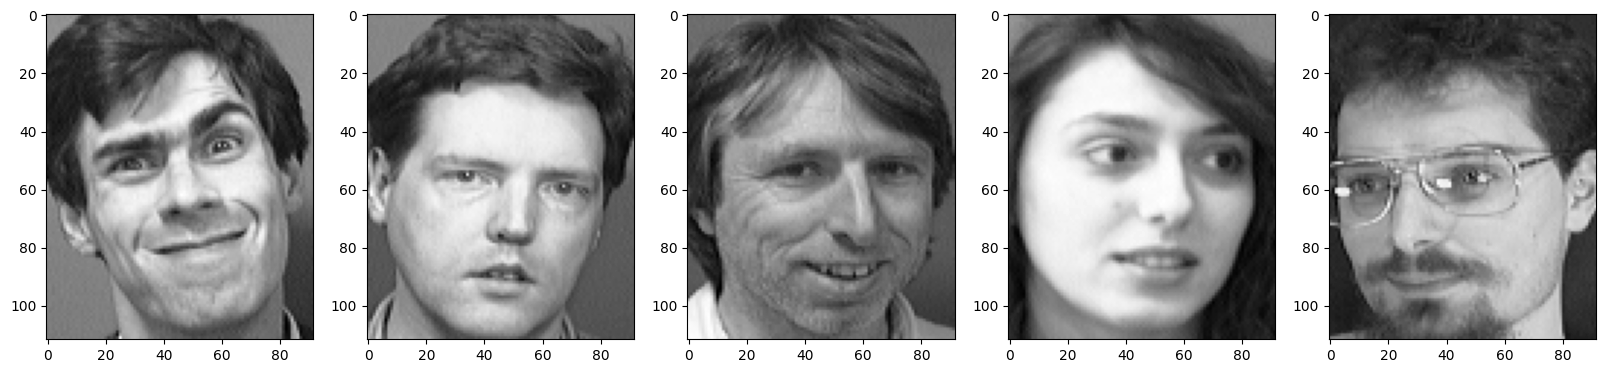

In [4]:
fig, ax = plt.subplots(1, 5, figsize = (20,30))

for i in range(5):
    ax[i].imshow(features[np.random.randint(0, 400),:].reshape(height, width), cmap="gray")

# 50-50 Split data

In [5]:
# split 50 50
train_features = []
train_labels = []
test_features = []
test_labels = []

test_features = features[::2]
test_labels = labels[::2]
train_features = features[1::2]
train_labels = labels[1::2]

test_features = np.array(test_features)
test_labels = np.array(test_labels)
train_features = np.array(train_features)
train_labels = np.array(train_labels)

print(train_features.shape)
print(train_labels.shape)

(200, 10304)
(200,)


# PCA

In [6]:
# Compute the mean
mean_data = np.mean(train_features, axis=0)
print(mean_data.shape)

(10304,)


In [7]:
# Centered the data
Z = train_features-mean_data
print(Z.shape)

(200, 10304)


In [8]:
# Compute the covariance matrix
cov = np.cov(Z, rowvar=False)
print(cov)

[[1325.50311558 1305.75698492 1311.22130653 ... -236.94351759
  -126.70874372  -75.91899497]
 [1305.75698492 1302.09839196 1299.8021608  ... -219.19959799
  -113.26949749  -64.62743719]
 [1311.22130653 1299.8021608  1312.67113065 ... -218.08502513
   -99.82439698  -49.53371859]
 ...
 [-236.94351759 -219.19959799 -218.08502513 ... 2517.64060302
  2005.48201005 1892.17708543]
 [-126.70874372 -113.26949749  -99.82439698 ... 2005.48201005
  1982.30429648 1868.90557789]
 [ -75.91899497  -64.62743719  -49.53371859 ... 1892.17708543
  1868.90557789 1978.77698492]]


In [9]:
# Compute eigenvectors and eigenvalues of the covariance matrix sorted descending
eig_values, eig_vectors = np.linalg.eigh(cov)
eig_values = np.flip(eig_values)
eig_vectors = np.flip(eig_vectors, axis=1)
print("Eigen values:")
print(eig_values)

print("Eigen vectors:")
print(eig_vectors)

Eigen values:
[ 2.78275844e+06  2.15255876e+06  1.07104866e+06 ... -5.14970643e-10
 -6.70506672e-10 -9.40552757e-10]
Eigen vectors:
[[ 1.24555558e-03  1.53617120e-02 -1.89107867e-02 ...  0.00000000e+00
   0.00000000e+00  0.00000000e+00]
 [ 1.26453637e-03  1.51314624e-02 -1.91177650e-02 ... -5.01912848e-02
   3.41497121e-01  6.81493489e-02]
 [ 1.56464522e-03  1.51619504e-02 -1.90394178e-02 ...  9.48973307e-02
  -3.39448957e-01 -4.26669668e-01]
 ...
 [ 8.73724732e-03 -9.61111754e-03 -1.28745102e-02 ... -4.66326931e-05
  -6.71555281e-03  5.64446593e-03]
 [ 7.21705083e-03 -7.75970197e-03 -1.37731826e-02 ...  1.89061515e-02
   2.51999262e-03  4.41772505e-04]
 [ 8.40080072e-03 -6.92707821e-03 -1.43881511e-02 ...  1.90391514e-03
   6.80979598e-04  3.06625871e-03]]


In [10]:
# choose smallest dimension for certain condition

eigen_sum = eig_values.sum()
alphas = [0.8, 0.85, 0.9, 0.95]
dimensions = []

for alpha in alphas:
  r = 0
  eigenValueAcc = eig_values[r]
  while eigenValueAcc / eigen_sum < alpha:
    r += 1
    eigenValueAcc += eig_values[r]

  dimensions.append(r)


dimensions = np.array(dimensions)
print(dimensions)



[ 36  52  76 115]


In [11]:
#reduced basis, matrix of eigenvectors colomns that corresponds to the eigenvalues
basis = []
for dim in dimensions:
  basis.append(eig_vectors[:, :dim])

print([basis.shape for basis in basis])

[(10304, 36), (10304, 52), (10304, 76), (10304, 115)]


In [12]:
# Projection on the new data
mean_test = np.mean(test_features, axis=0)
test_centered = test_features - mean_test


reduced_train = [Z @ base for base in basis]
reduced_test = [test_centered @ base for base in basis]



In [13]:
[x.shape for x in reduced_train]

[(200, 36), (200, 52), (200, 76), (200, 115)]

In [14]:
[x.shape for x in reduced_test]

[(200, 36), (200, 52), (200, 76), (200, 115)]

# KNN

In [15]:
models = [KNN() for _ in range(len(alphas))]

params = {
    "n_neighbors": list(range(1,9,2))
}

models_cv = [GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")
                       for model in models]

In [16]:
test_accuracies = []
for i, proj in enumerate(reduced_train):
    models_cv[i].fit(proj, train_labels)
    results = pd.DataFrame(models_cv[i].cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score"]]

    pred = models_cv[i].best_estimator_.predict(reduced_test[i])
    acc = np.mean(pred == test_labels)
    test_accuracies.append(acc)
    print(f"alpha: {alphas[i]}\n", knn_selected_results)

alpha: 0.8
   param_n_neighbors  mean_test_score
0                 1            0.895
1                 3            0.810
2                 5            0.720
3                 7            0.695
alpha: 0.85
   param_n_neighbors  mean_test_score
0                 1            0.905
1                 3            0.820
2                 5            0.725
3                 7            0.710
alpha: 0.9
   param_n_neighbors  mean_test_score
0                 1            0.900
1                 3            0.805
2                 5            0.700
3                 7            0.675
alpha: 0.95
   param_n_neighbors  mean_test_score
0                 1            0.905
1                 3            0.795
2                 5            0.715
3                 7            0.660


Text(0, 0.5, 'classification accuracy')

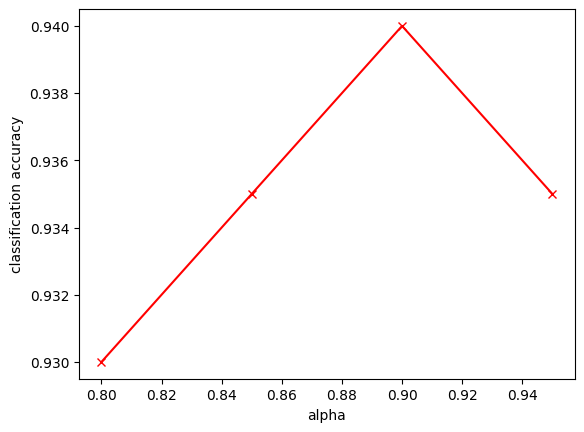

In [17]:
fig = plt.figure()
plt.plot(alphas, test_accuracies, linestyle='-', marker='x', color='red')
plt.xlabel("alpha")
plt.ylabel("classification accuracy")

In [18]:
# k = [1, 3, 5, 7]
# fig = plt.figure()



# plt.plot(k, results['mean_test_score'], linestyle='-', marker='x', color='red')
# plt.xlabel("k")
# plt.ylabel("accuracy")

In [19]:
def test(model, x, images, y, tests = 7):

    fig, axes = plt.subplots(1, tests, figsize=(12,8))

    for ax in axes:
        ind = np.random.randint(0, len(x))
        features = x[ind].reshape(1,-1)
        label = y[ind]
        img = images[ind]
        pred = model.predict(features)

        ax.set_title(f"label = {label} \nprediction = {pred.item()}")
        ax.imshow(img.reshape(height, width), cmap="gray")


    fig.tight_layout()

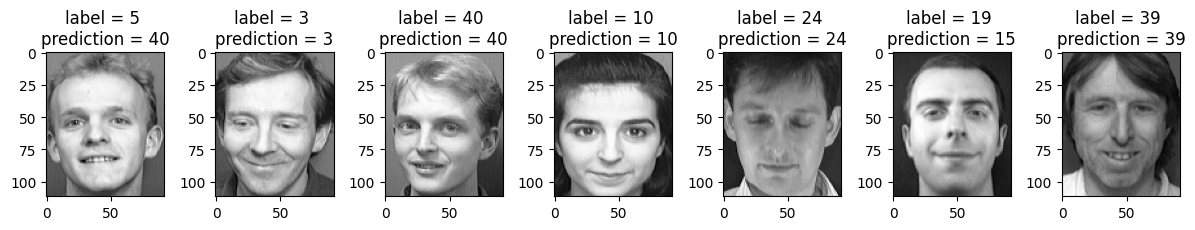

In [38]:
test(models_cv[2].best_estimator_, reduced_test[2], test_features, test_labels)

# Bonus classification for 70-30 split

In [21]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, train_size=0.7,
                                                        random_state=0, stratify=labels,)

# PCA

In [22]:
# Compute the mean
mean_data = np.mean(train_features, axis=0)
print(mean_data.shape)

(10304,)


In [23]:
# Centered the data
Z = train_features-mean_data
print(Z.shape)

(280, 10304)


In [24]:
# Compute the covariance matrix
cov = np.cov(Z, rowvar=False)
print(cov)

[[1310.24326677 1291.89144905 1283.1578597  ... -175.73256528
  -127.8311828   -43.27680492]
 [1291.89144905 1290.41986687 1274.56784434 ... -170.54429083
  -124.19354839  -45.359447  ]
 [1283.1578597  1274.56784434 1272.04295955 ... -181.12857143
  -130.89139785  -50.05826933]
 ...
 [-175.73256528 -170.54429083 -181.12857143 ... 2204.64818228
  1945.17311828 1767.48858167]
 [-127.8311828  -124.19354839 -130.89139785 ... 1945.17311828
  2008.24265233 1858.71469534]
 [ -43.27680492  -45.359447    -50.05826933 ... 1767.48858167
  1858.71469534 1923.66799795]]


In [25]:
# Compute eigenvectors and eigenvalues of the covariance matrix sorted descending
eig_values, eig_vectors = np.linalg.eigh(cov)
eig_values = np.flip(eig_values)
eig_vectors = np.flip(eig_vectors, axis=1)
print("Eigen values:")
print(eig_values)

print("Eigen vectors:")
print(eig_vectors)

Eigen values:
[ 2.89409628e+06  2.10114039e+06  1.08895253e+06 ... -8.64259625e-10
 -8.67081786e-10 -1.07044619e-09]
Eigen vectors:
[[ 0.00335147  0.01499703 -0.01956082 ...  0.          0.
   0.        ]
 [ 0.00332772  0.01494716 -0.01964829 ... -0.37957501  0.29525295
  -0.21206775]
 [ 0.00331297  0.014964   -0.0192602  ...  0.29887447 -0.11086791
   0.33170991]
 ...
 [ 0.007562   -0.01144858 -0.01335969 ... -0.00436473 -0.00535849
   0.00715555]
 [ 0.00694537 -0.01042761 -0.0143306  ... -0.00107783  0.01837715
  -0.00099967]
 [ 0.00749419 -0.00880505 -0.01477851 ...  0.00337315 -0.0069044
  -0.00605662]]


In [26]:
# choose smallest dimension for certain condition

eigen_sum = eig_values.sum()
alphas = [0.8, 0.85, 0.9, 0.95]
dimensions = []

for alpha in alphas:
  r = 0
  eigenValueAcc = eig_values[r]
  while eigenValueAcc / eigen_sum < alpha:
    r += 1
    eigenValueAcc += eig_values[r]

  dimensions.append(r)


dimensions = np.array(dimensions)
print(dimensions)



[ 39  59  91 147]


In [27]:
#reduced basis, matrix of eigenvectors colomns that corresponds to the eigenvalues
basis = []
for dim in dimensions:
  basis.append(eig_vectors[:, :dim])

print([basis.shape for basis in basis])

[(10304, 39), (10304, 59), (10304, 91), (10304, 147)]


In [28]:
# Projection od the new data
mean_test = np.mean(test_features, axis=0)
test_centered = test_features - mean_test


reduced_train = [Z @ base for base in basis]
reduced_test = [test_centered @ base for base in basis]



In [29]:
[x.shape for x in reduced_train]

[(280, 39), (280, 59), (280, 91), (280, 147)]

In [30]:
[x.shape for x in reduced_test]

[(120, 39), (120, 59), (120, 91), (120, 147)]

# KNN

In [31]:
models = [KNN() for _ in range(len(alphas))]

params = {
    "n_neighbors": list(range(1,9,2))
}

models_cv = [GridSearchCV(model, param_grid=params, cv=5,
                       return_train_score=True, scoring="accuracy")
                       for model in models]

In [32]:
test_accuracies = []
for i, proj in enumerate(reduced_train):
    models_cv[i].fit(proj, train_labels)
    results = pd.DataFrame(models_cv[i].cv_results_)
    knn_selected_results = results[["param_n_neighbors", "mean_test_score"]]

    pred = models_cv[i].best_estimator_.predict(reduced_test[i])
    acc = np.mean(pred == test_labels)
    test_accuracies.append(acc)
    print(f"alpha: {alphas[i]}\n", knn_selected_results)

alpha: 0.8
   param_n_neighbors  mean_test_score
0                 1         0.950000
1                 3         0.892857
2                 5         0.832143
3                 7         0.803571
alpha: 0.85
   param_n_neighbors  mean_test_score
0                 1         0.953571
1                 3         0.907143
2                 5         0.846429
3                 7         0.782143
alpha: 0.9
   param_n_neighbors  mean_test_score
0                 1         0.960714
1                 3         0.885714
2                 5         0.832143
3                 7         0.775000
alpha: 0.95
   param_n_neighbors  mean_test_score
0                 1         0.946429
1                 3         0.878571
2                 5         0.821429
3                 7         0.775000


Text(0, 0.5, 'classification accuracy')

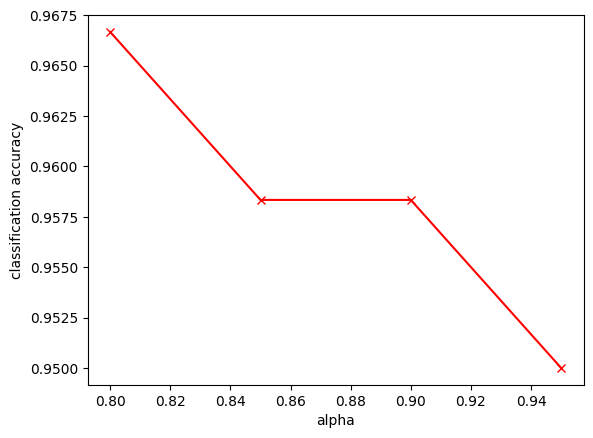

In [33]:
fig = plt.figure()
plt.plot(alphas, test_accuracies, linestyle='-', marker='x', color='red')
plt.xlabel("alpha")
plt.ylabel("classification accuracy")

In [34]:
# k = [1, 3, 5, 7]
# fig = plt.figure()



# plt.plot(k, results['mean_test_score'], linestyle='-', marker='x', color='red')
# plt.xlabel("k")
# plt.ylabel("accuracy")

In [35]:
def test(model, x, images, y, tests = 7):

    fig, axes = plt.subplots(1, tests, figsize=(12,8))

    for ax in axes:
        ind = np.random.randint(0, len(x))
        features = x[ind].reshape(1,-1)
        label = y[ind]
        img = images[ind]
        pred = model.predict(features)

        ax.set_title(f"label = {label} \nprediction = {pred.item()}")
        ax.imshow(img.reshape(height, width), cmap="gray")


    fig.tight_layout()

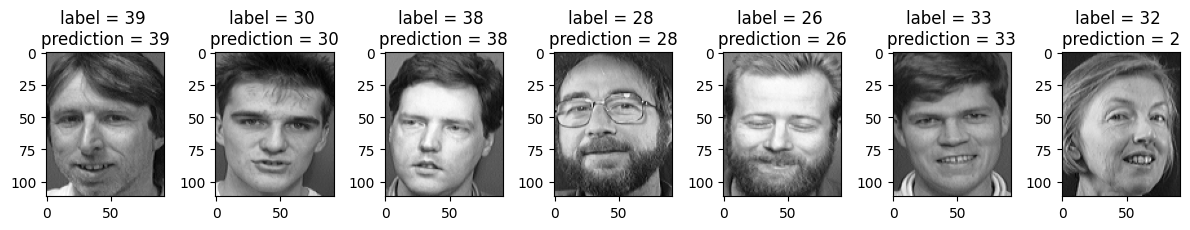

In [48]:
test(models_cv[2].best_estimator_, reduced_test[2], test_features, test_labels)